# Lab 6: Convolutional Neural Network

### *Harrison Noble & Henry Lambson*

***

__Dataset Selection__

Select a dataset identically to lab two (images). That is, the dataset must be image data. In terms of generalization performance, it is helpful to have a large dataset of identically sized images. It is fine to perform binary classification or multi-class classification.

In [2]:
import os
import zipfile
import glob
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from PIL import Image
from sklearn.utils import shuffle

In [4]:
#This preprocessing code is modified from our Lab 2 report

#unzip data (only do once, uncomment to unzip data)
#with zipfile.ZipFile('dataset.zip', 'r') as zipf:
#    zipf.extractall('./data')

fake_face_path = 'data/real_and_fake_face/training_fake/*'
real_face_path = 'data/real_and_fake_face/training_real/*'

#desired height and width of images
h = 100
w = 100

tf.random.set_seed(2)
np.random.seed(0)

def load_data(path):
    files = glob.glob(path)
    img_list = []
    classes = []
    for file in files:
        #create image, convert to grayscale, resize to 100x100
        img = np.asarray(Image.open(file).convert('L').resize((h, w)))
        img_list.append(img)
        _, fname = os.path.split(file)
        classes.append(1 if 'real' in fname else 0)
    
    return np.asarray(img_list), classes

fake_list, fake_classes = load_data(fake_face_path)
real_list, real_classes = load_data(real_face_path)
print('Fake images dataset shape:', fake_list.shape)
print('Real images dataset shape:', real_list.shape)

#combine data, normalize pixel data, shuffle
data = np.concatenate((fake_list, real_list), axis=0)
data = np.expand_dims(data, axis=-1)/255 - 0.5
classes = fake_classes + real_classes
data, classes = shuffle(data, classes, random_state=0)

print('Total dataset shape:', data.shape)
print('Total number of classification targets:', len(classes))

Fake images dataset shape: (960, 100, 100)
Real images dataset shape: (1081, 100, 100)
Total dataset shape: (2041, 100, 100, 1)
Total number of classification targets: 2041


The above code is a modified version of our loading and pre-processing from Lab 2. This code loads all the images, converts to grayscale, uniformally resizes them to 100x100 pixels, and normalizes the pixel values. Our preprocessed image dataset is stored as the ```data``` numpy array. Additionally, the class labels for each image are stored in the ```classes``` list. 

Our dataset contains 960 edited/fake images (47%) and 1081 real images of people (53%), which is balanced fairly well. The main classification task of our dataset is to determine whether a given image is fake or real. We think this can be incorporated into a social media site that runs a preliminary screening over a photo before it is posted to flag all edited photos for review.

The shape of our combined fake and real image dataset is 2041x100x100x1, meaning there are 2041 images, each of size 100x100 pixels with 1 color channel (grayscale).

0 = Fake Image, 1 = Real Image


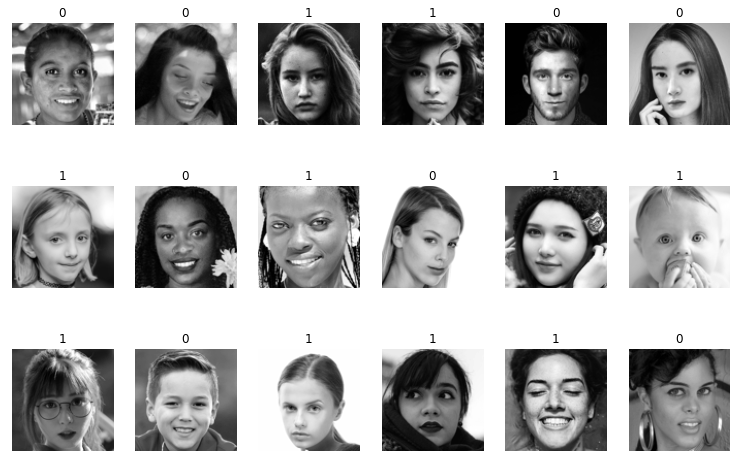

In [6]:
#taken from your 11. Convolutional Neural Networks notebook
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    print('0 = Fake Image, 1 = Real Image')
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].squeeze(), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(data, classes, 100, 100)

The above images show a small subset of our data. The images with a label of 1 are real photos and images with a label of 0 are fake, edited photos. Some fake images are much harder to distinguish from real ones, while some are very easy to distinguish. 

***

## 1 Preparation

### 1.1 Evaluation Metric Selection

Although our dataset is fairly balanced and we care about both classes equally, we decided to go with the F1-Score for our evaluation metric. F1-Score is the middle ground between precision and recall. Precision measures the true positives over all predicted positives (false positives) and recall measures the predicted positives instance to the total number of positive instances (false negatives). In our case, we want to minimize both false positives and false negatives, which is why we think F1-Score is a good evaluation metric. If our model were to be used as a preliminary screening method for a social media site, we would not want to flag legitimate photos as edited (false positive), nor would we want to let an edited picture get through our algorithm (false negative). A high false positive rate would lead to an unnecessary amount of flagging, whereas a high false negative rate would render our "edited photo detection" algorithm fairly useless.

Below is the code used to calculate the F1-Score evaluation metric which will be passed into our models later.

In [7]:
from tensorflow.keras import backend as K

#code used from [2]
def f1(y_true, y_pred):
    #calc recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    
    #calc precision
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())

    #calc f1 score
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### 1.2 Method to Divide Data into Training & Testing

We decided to use an 80/20 stratified shuffle split to divide our data into training and testing sets. We believe stratified shuffle split works with our dataset as it is fairly balanced already, and this method of splitting the data would further preserve this balance. Due to hardware/time constrains (CNN training time and plenty of other projects due), we decided not to use stratified K-fold cross validation as this significantly increases the time to train the models. Additionally, by using data expansion we can increase the number of images our model trains on. Therefore we believe an 80/20 stratified shuffle split is sufficient for our modeling needs.

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

X = data
y = np.asarray(classes)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_idx, test_idx in sss.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

print("X_train shape:", X_train.shape, ", y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape, ", y_test shape:", y_test.shape)

X_train shape: (1632, 100, 100, 1) , y_train shape: (1632,)
X_test shape: (409, 100, 100, 1) , y_test shape: (409,)


From those numbers, we can see that the data has been split into 80% training and 20% testing, lets make sure the class balance stayed around 47% for the fake images and 53% for the real images.

In [12]:
print("y_train class balance:", np.bincount(y_train))
print("y_test class balance:", np.bincount(y_test))

y_train class balance: [768 864]
y_test class balance: [192 217]


Looks good, the class with the smaller number of instances makes up about 47% of both training and testing data.

***

## 2 Modeling

### 2.1 Data Expansion

For data expansion, we decided to use the Keras ```ImageDataGenerator``` to modify/expand our data. We settled on using augmentation like image rotation, shifting the height and width, messing with zooming in, and flipping the image horizontally. We thought these were good apsects to change as our data is comprised of photos of people and people can do a variety of different poses in their pictures. Not every picture we send through our algorithm is going to be a straight on headshot so we are accounting for that during data augmentation/expansion.

0 = Fake Image, 1 = Real Image


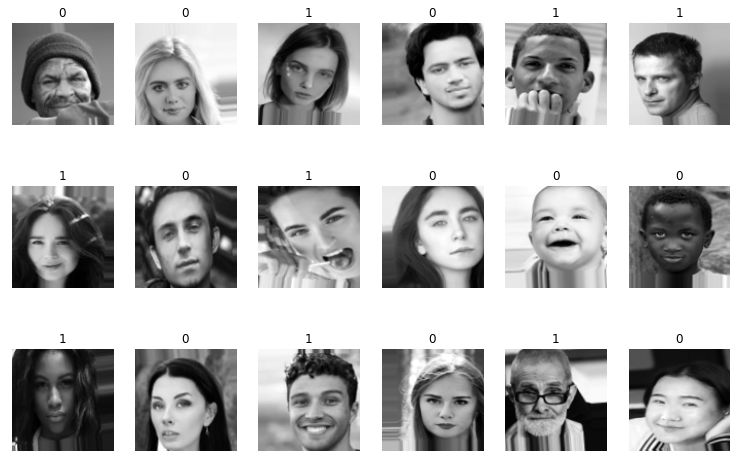

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    data_format="channels_last")

datagen.fit(X_train)
tmps = datagen.flow(X_train, y_train, batch_size=18)

plot_gallery(tmps[0][0], tmps[0][1], 100, 100)

From the above image outputs we can see how the images look slightly altered from a normal image. Visibly, we can see that some of the faces have been shifted towards the edges of the frame while some are rotated slightly.

### 2.2 Convolutional Neural Networks

- __[2 points]__ Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures (and investigate changing some parameters of each architecture--at minimum have two variations of each network for a total of four models trained). Use the method of train/test splitting and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras).
- *Note: Create 2 convnets (number of layers, residual paths, separable convolutions, etc.), also change some parameters (num filters, kernel size, max pooling params, etc.)*

In [25]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Reshape, Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import average
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2

In [23]:
#helper function to print plots of evaluation metric and loss function over # of epochs
def plot_history(hist):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.title('Evaluation Metric')
    plt.plot(hist.history['f1'])
    plt.plot(hist.history['val_f1'])
    plt.ylabel('F1-Score')
    plt.xlabel('epochs')
    plt.subplot(1,2,2)
    plt.title('Loss Function')
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epochs')
    plt.show()

In [27]:
cnn1 = Sequential()

# let's start with an AlexNet style convolutional phase
cnn1.add(Conv2D(filters=32,
                input_shape = (100,100,1),
                kernel_size=(3,3), 
                padding='same', 
                activation='relu', 
                data_format="channels_last"))

# no max pool before next conv layer!!
cnn1.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu'))
cnn1.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

# add one layer on flattened output
cnn1.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn1.add(Flatten())
cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn1.add(Dense(1, activation='softmax'))

cnn1.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=[f1])

history = cnn1.fit(datagen.flow(X_train, y_train, batch_size=64), 
                   steps_per_epoch=int(len(X_train)/64),
                   epochs=10,
                   verbose=1,
                   validation_data=(X_test,y_test))

Epoch 1/10
25/25 [==============================] - 70s 3s/step - loss: 0.9852 - f1: 0.7042 - val_loss: 0.6929 - val_f1: 0.6879
Epoch 2/10
25/25 [==============================] - 58s 2s/step - loss: 0.6929 - f1: 0.6861 - val_loss: 0.6927 - val_f1: 0.6879
Epoch 3/10
25/25 [==============================] - 58s 2s/step - loss: 0.6925 - f1: 0.6834 - val_loss: 0.6921 - val_f1: 0.6879
Epoch 4/10
25/25 [==============================] - 53s 2s/step - loss: 0.6917 - f1: 0.6780 - val_loss: 0.6909 - val_f1: 0.6879
Epoch 5/10
25/25 [==============================] - 54s 2s/step - loss: 0.6919 - f1: 0.6804 - val_loss: 0.6896 - val_f1: 0.6879
Epoch 6/10
25/25 [==============================] - 58s 2s/step - loss: 0.6882 - f1: 0.6919 - val_loss: 0.6914 - val_f1: 0.6879
Epoch 7/10
25/25 [==============================] - 54s 2s/step - loss: 0.6922 - f1: 0.6766 - val_loss: 0.6909 - val_f1: 0.6879
Epoch 8/10
25/25 [==============================] - 55s 2s/step - loss: 0.6913 - f1: 0.6835 - val_loss: 

### 2.3 Analyzing & Visualizing CNN Results

- __[1.5 points]__ Visualize the final results of the CNNs and interpret the performance. Use proper statistics as appropriate, especially for comparing models. 
- *Note: Statistical comparison, loss/metric graphs, relate back to business/use case.*

### 2.4 Comparing CNN to Standard Multi-Layer Perceptron

- __[1 points]__ Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.  
- *Note: Compare to MLP with proper statistical techniques and ROC/AUC*

***

## 3 Exceptional Work

Opting for late turn-in, no exceptional work this time :(

***

## Resources

[1] Real and Fake Face Dataset. https://www.kaggle.com/ciplab/real-and-fake-face-detection

[2] Calculating F1-Score with Keras. https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

[3]